# Whistle Detection and Analysis with AutomaticExtraction

This notebook demonstrates how to:
1. Load and process audio files
2. Detect whistles using a pre-trained model
3. Extract whistle contours from detections
4. Visualize and analyze the results
5. Cluster similar whistles

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.io import loadmat, wavfile


# Import from the correct paths
from AutomaticExtraction.src.extraction.contour import (
    vectorize_whistle_contours_from_file,
    split_wh_zones,
    distance_wh_zones,
    Extract_Whistles
)


from AutomaticExtraction.src.extraction.clustering import (
    cluster_whistles,
    extract_cluster_representatives,
    visualize_clusters
)

from AutomaticExtraction.src.utils.helpers import merge_consecutive_windows
from AutomaticExtraction.src.audio.spectrogram import compute_spectrogram

## 1. Load and Process Audio Data

First, we'll load a WAV file and its corresponding whistle detection predictions.

In [26]:
# Define paths to audio and prediction files
audio_path = "examples/Exp_11_Aug_2021_1549_channel_1.wav"  # Replace with your audio file
csv_path = "examples/Exp_11_Aug_2021_1549_channel_1/Exp_11_Aug_2021_1549_channel_1.wav_predictions.csv"  # Replace with your CSV file

# Load the predictions CSV file
csv_df = pd.read_csv(csv_path)
print(f"Loaded {len(csv_df)} whistle detections")
csv_df.head()

Loaded 76 whistle detections


file_name  initial_point  finish_point  confidence
0  Exp_11_Aug_2021_1549_channel_1.wav            2.8           3.2    0.720453
1  Exp_11_Aug_2021_1549_channel_1.wav            3.2           3.6    0.996408
2  Exp_11_Aug_2021_1549_channel_1.wav            4.0           4.4    0.598746
3  Exp_11_Aug_2021_1549_channel_1.wav            5.2           5.6    0.999841
4  Exp_11_Aug_2021_1549_channel_1.wav            5.6           6.0    1.000000

## 2. Merge Consecutive Detection Windows

Consecutive detection windows are merged to form continuous whistle segments.

In [27]:
# Merge consecutive detection windows
detections_df = merge_consecutive_windows(csv_df)
print(f"Merged into {len(detections_df)} continuous whistle segments")
detections_df.head()

Merged into 12 continuous whistle segments


file_name  initial_point  finish_point  confidence
0  Exp_11_Aug_2021_1549_channel_1.wav            2.8           3.6    0.858431
1  Exp_11_Aug_2021_1549_channel_1.wav            4.0           4.4    0.598746
2  Exp_11_Aug_2021_1549_channel_1.wav            5.2           8.0    0.998768
3  Exp_11_Aug_2021_1549_channel_1.wav           13.6          18.0    0.999670
4  Exp_11_Aug_2021_1549_channel_1.wav           19.2          20.0    0.798058

## 3. Extract Whistle Contours

Now we'll extract the frequency contours of the detected whistles.

In [28]:
# Extract whistle contours directly from the file
output_csv = "examples/Exp_11_Aug_2021_1549_channel_1/extracted_contours.csv"
wht, whf = vectorize_whistle_contours_from_file(audio_path, csv_path, output_csv,
                                                min_freq=3000, max_freq=30000,
                                                window_size=3, delta=5,
                                                smoothing_window=5,
                                                noise_reduction=True, edge_detection=True)

print(f"Extracted {len(wht)} contour points")

Processing whistle zones:   0%|          | 0/76 [00:00<?, ?it/s]/export/home1/users/zfne/mustun/Documents/GitHub/Dolphins/AutomaticExtraction/src/extraction/contour.py:166: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_freqs = smoothed_freqs.fillna(method='bfill').fillna(method='ffill')
Processing whistle zones: 100%|██████████| 76/76 [00:07<00:00, 10.30it/s]

Extracted 2736 contour points


## 4. Generate Spectrogram for Visualization

We'll create a spectrogram of the audio file to visualize the whistles.

In [29]:
# Load the audio file
fs, x = wavfile.read(audio_path)

# Generate spectrogram
specgram, freqs, times = compute_spectrogram(
    x,
    fs,
    stride_ms=10.0,
    window_ms=20.0,
    max_freq=30000,
    min_freq=1000
)

print(f"Generated spectrogram with shape {specgram.shape}")

Generated spectrogram with shape (581, 6005)


## 5. Visualize Whistle Contours on Spectrogram

Now we'll plot the extracted whistle contours on top of the spectrogram.

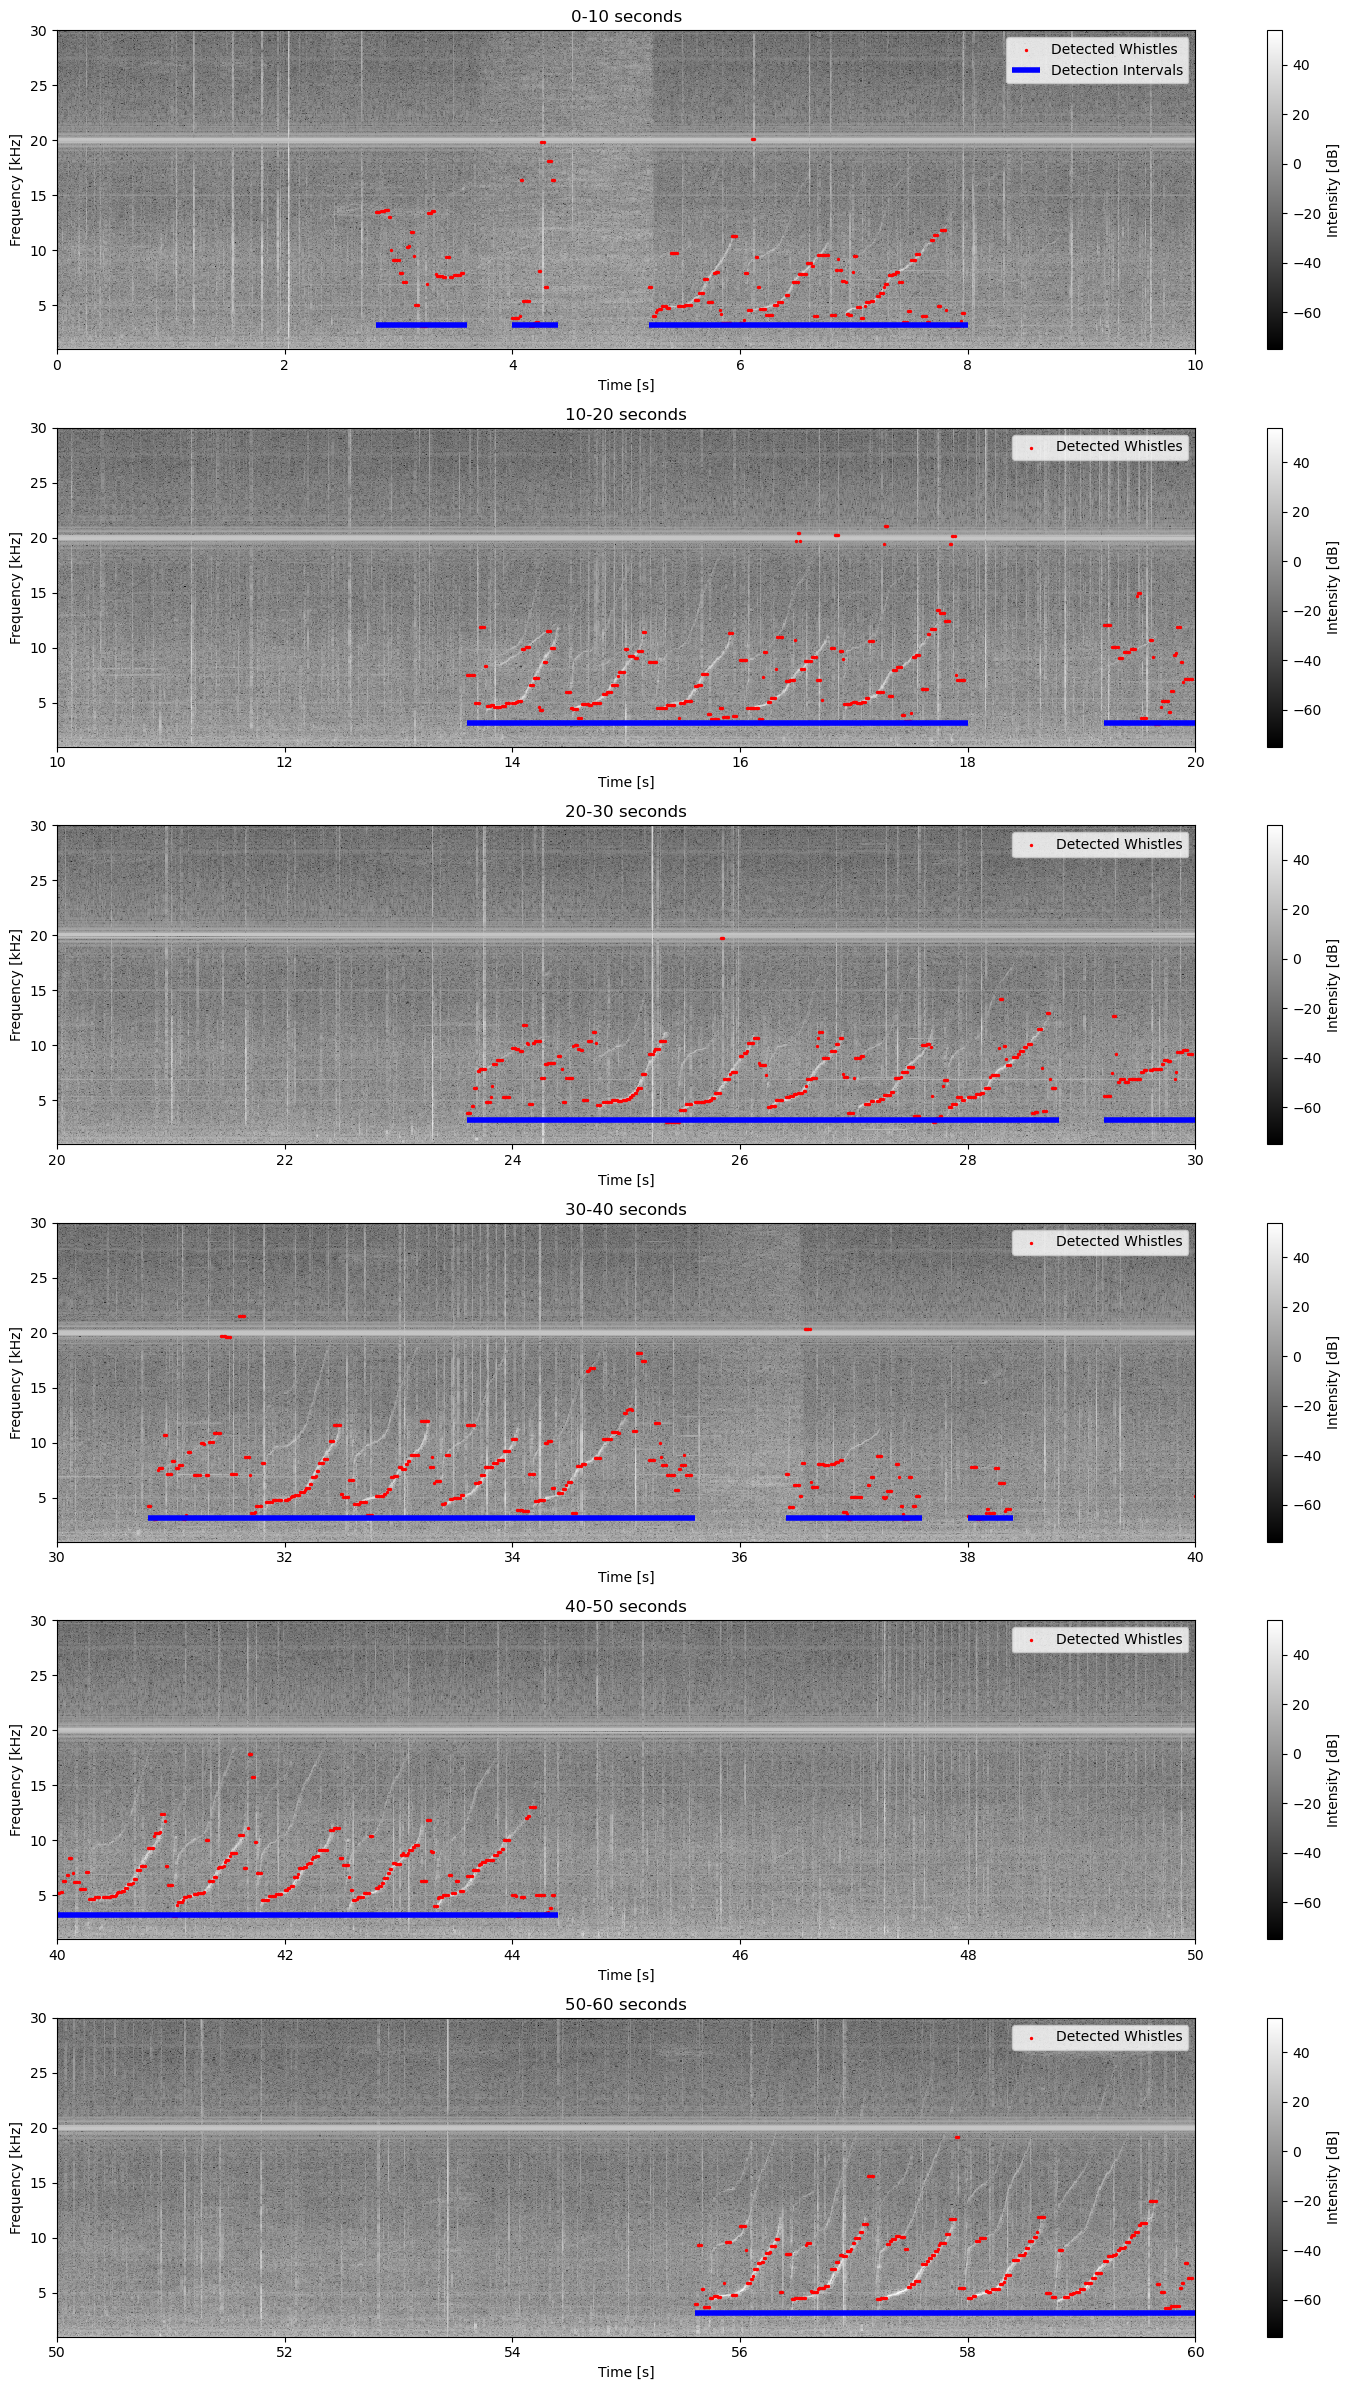

In [30]:
# Create a figure with 6 subplots (one for every 10 seconds)
plt.figure(figsize=(15, 24))
for i in range(6):
    ax = plt.subplot(6, 1, i+1)
    
    # Calculate time range for this subplot
    start_time = i * 10
    end_time = (i + 1) * 10
    
    # Plot spectrogram
    im = ax.pcolormesh(times, freqs/1000, 10 * np.log10(specgram + 1e-14), cmap='gray')
    plt.colorbar(im, ax=ax, label='Intensity [dB]')
    
    # Plot vectorized whistles
    mask = (wht >= start_time) & (wht <= end_time)
    ax.scatter(wht[mask], whf[mask]/1000, c='r', s=2, label='Detected Whistles')
    
    # Add detection intervals
    for _, row in detections_df.iterrows():
        start = row['initial_point']
        end = row['finish_point']
        if start >= i * 10 and end <= (i + 1) * 10:  # Only plot intervals within this 10-second range
            ax.hlines(y=3.2, xmin=start, xmax=end, colors='blue', linewidth=4,
                      label='Detection Intervals' if _ == 0 else "")
    
    # Customize subplot
    ax.set_ylim(1, 30)
    ax.set_xlim(i * 10, (i + 1) * 10)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [kHz]')
    ax.set_title(f'{i * 10}-{(i + 1) * 10} seconds')
    ax.legend()

plt.tight_layout()
plt.show()

## 6. Prepare Contours for Clustering

Now we'll prepare the whistle contours for clustering by organizing them into segments.

In [31]:
# Split the contours into individual whistles
whistle_contours = split_wh_zones(wht, whf)
print(f"Split into {len(whistle_contours)} individual whistle contours")

Split into 6 individual whistle contours


## 7. Cluster Similar Whistle Contours

Now we'll cluster the whistle contours to find similar patterns.

Computing DTW distances: 100%|██████████| 6/6 [00:00<00:00, 17.91it/s]


Found 1 clusters and 0 noise points
Extracted 1 representative contours


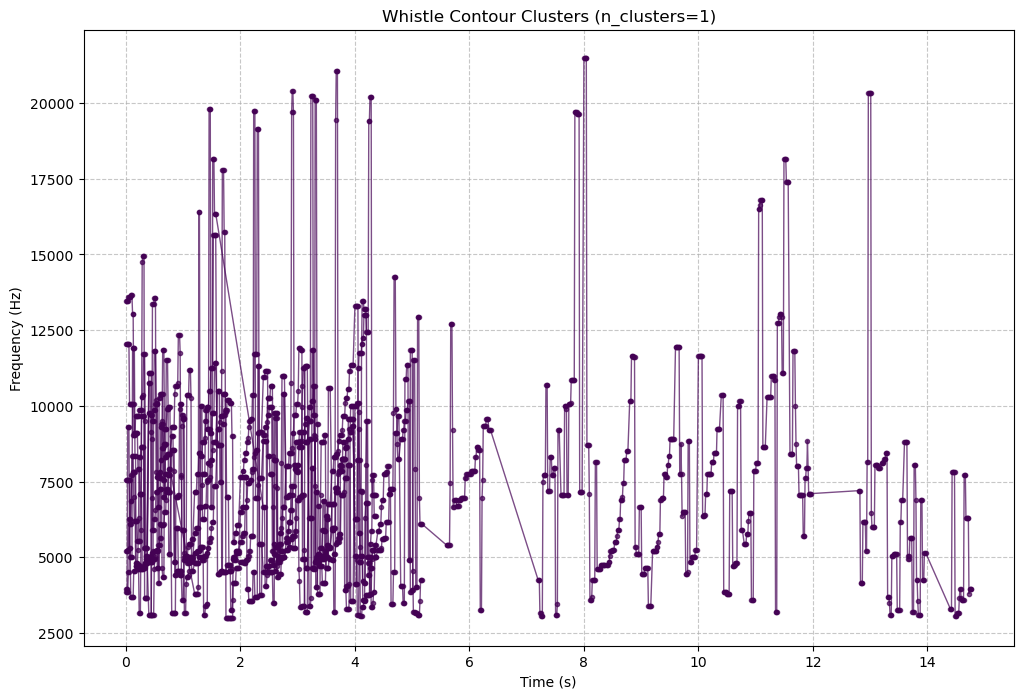

In [32]:
# Only proceed with clustering if we have enough contours
if len(whistle_contours) >= 2:
    # Cluster the whistle contours
    labels, distance_matrix = cluster_whistles(
        whistle_contours, 
        distance_threshold=0.3,  # Adjust based on your data
        min_samples=2
    )
    
    # Count clusters
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"Found {n_clusters} clusters and {n_noise} noise points")
    
    # Extract representative contours for each cluster
    representatives = extract_cluster_representatives(whistle_contours, labels)
    print(f"Extracted {len(representatives)} representative contours")
    
    # Visualize the clusters
    visualize_clusters(whistle_contours, labels)
else:
    print("Not enough whistle contours for clustering")

## 8. Visualize Representative Contours

Finally, we'll visualize the representative contours from each cluster.

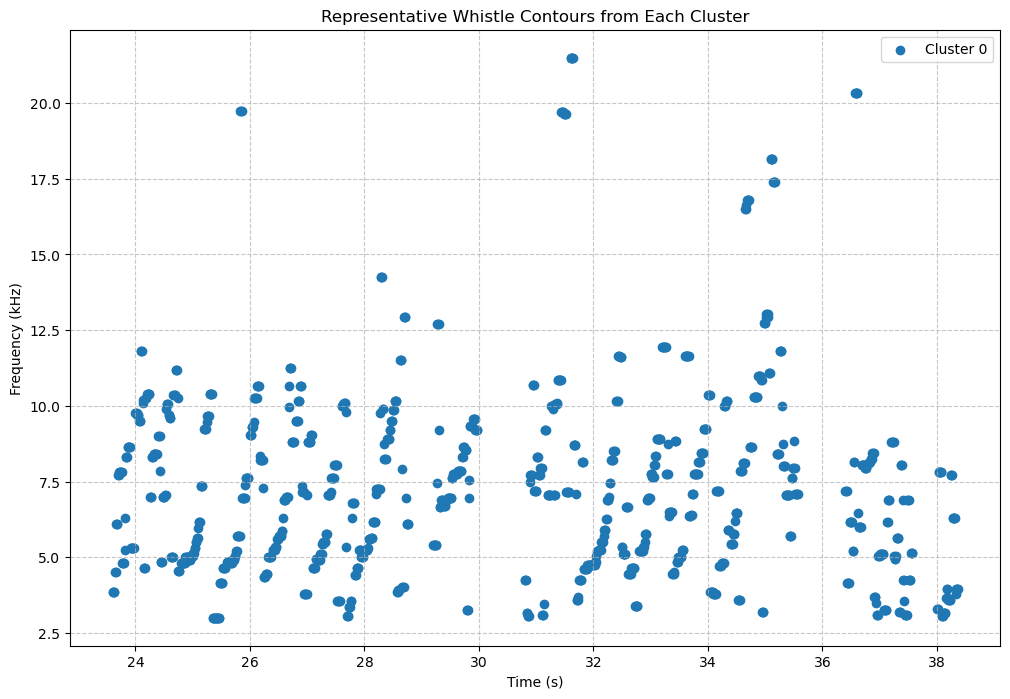

In [33]:
# Only proceed if we have representatives
if 'representatives' in locals() and representatives:
    plt.figure(figsize=(12, 8))
    
    # Plot each representative contour
    for label, contour in representatives.items():
        plt.scatter(contour[:, 0], contour[:, 1]/1000, label=f'Cluster {label}')
    
    plt.title('Representative Whistle Contours from Each Cluster')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (kHz)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
else:
    print("No representative contours to visualize")

In [ ]:
filepath_annotation = "/users/zfne/mustun/Documents/GitHub/Dolphins/examples/templates/SW_Yosefa.csv"
annots = pd.read_csv(filepath_annotation)
## Get frequency and time 
annots_freqs = annots['frequency'].values
annots_times = annots['time'].values
annots_name = filepath_annotation.split('/')[-1].split('.')[0]

Distance = distance_wh_zones(wht, whf, annots_freqs, annots_times, n_jobs=36)
Wh, whistles_index = Extract_Whistles(Distance, whf, wht, annots_times, annots_freqs, 
                                      threshold=0.15, width=10, n_jobs=36)

100%|██████████| 2736/2736 [00:00<00:00, 4483.87it/s]


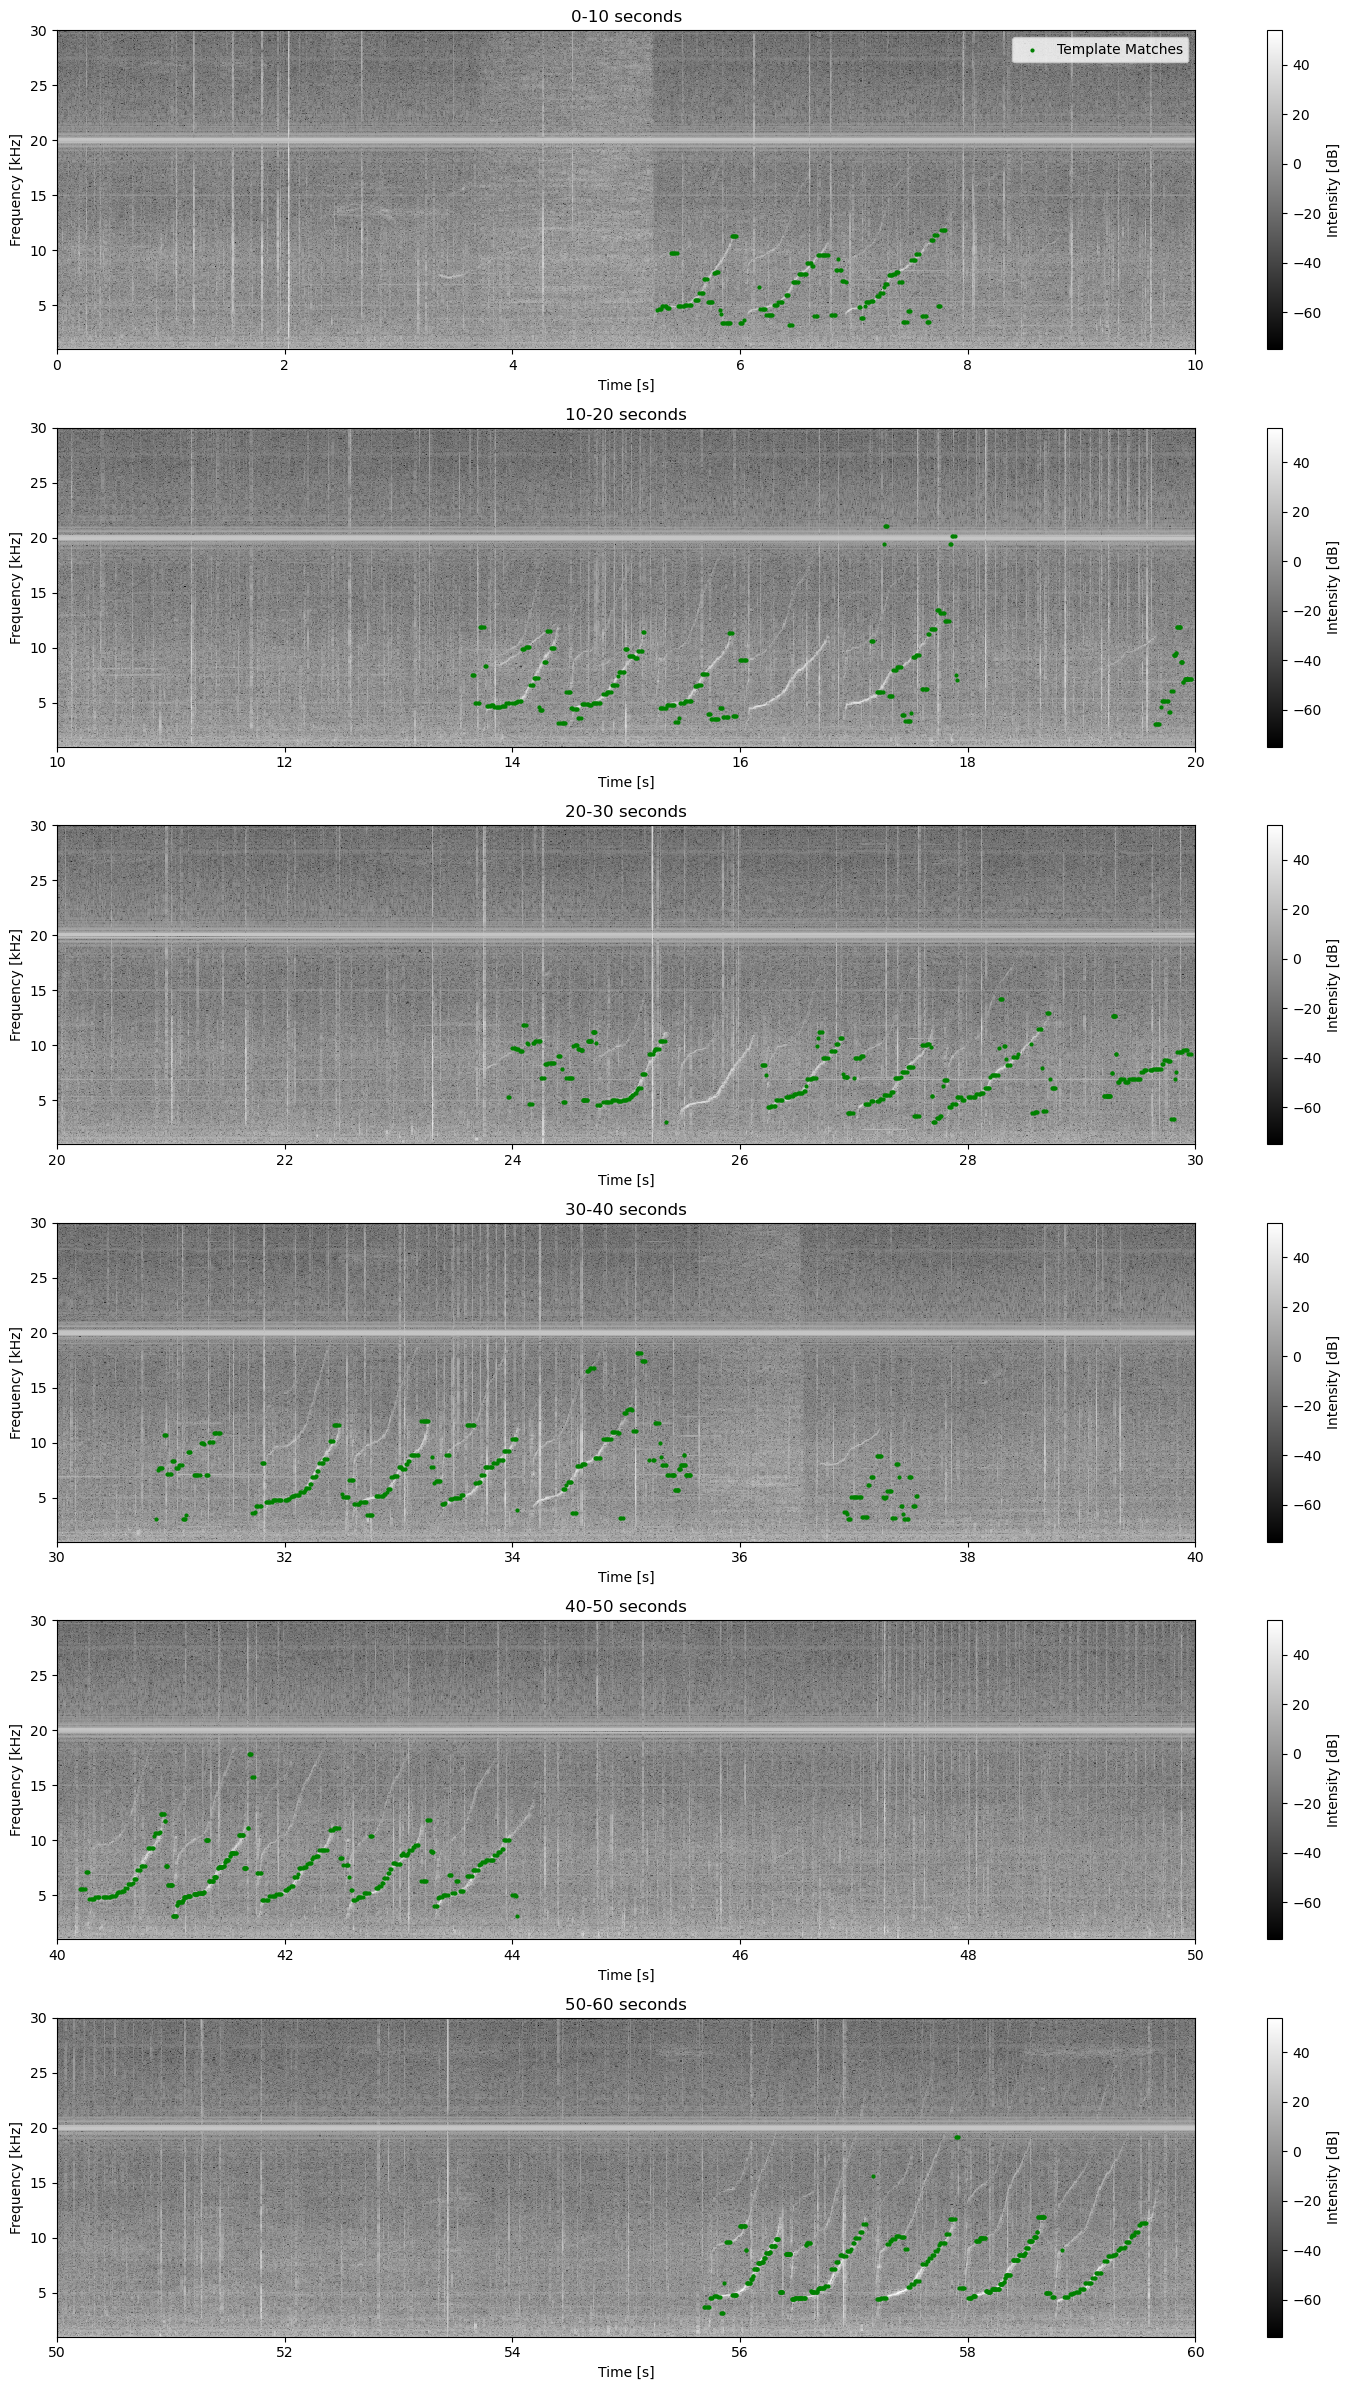

In [35]:
# Plot the extracted whistles on the spectrogram by 10-second segments
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 24))
axes = axes.flatten()

# Number of 10-second segments to plot
num_segments = min(12, int(np.ceil(np.max(wht) / 10)))

for i in range(num_segments):
    ax = axes[i]
    
    # Calculate time range for this subplot
    start_time = i * 10
    end_time = (i + 1) * 10
    
    # Plot spectrogram
    im = ax.pcolormesh(times, freqs/1000, 10 * np.log10(specgram + 1e-14), cmap='gray')
    plt.colorbar(im, ax=ax, label='Intensity [dB]')
    
    # Plot original vectorized whistles
    mask = (wht >= start_time) & (wht <= end_time)
    #ax.scatter(wht[mask], whf[mask]/1000, c='r', s=2, label='Detected Whistles')
    
    # Plot extracted whistles from template matching
    for wh in Wh:
        wh_times = wh['wht']
        wh_freqs = wh['whf']
        wh_mask = (wh_times >= start_time) & (wh_times <= end_time)
        if np.any(wh_mask):
            ax.scatter(wh_times[wh_mask], wh_freqs[wh_mask]/1000, c='g', s=4, 
                      label='Template Matches' if wh is Wh[0] else "")
    
    # Customize subplot
    ax.set_ylim(1, 30)
    ax.set_xlim(i * 10, (i + 1) * 10)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [kHz]')
    ax.set_title(f'{i * 10}-{(i + 1) * 10} seconds')
    
    # Add legend but only for the first plot to avoid redundancy
    if i == 0:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


## 9. Save Results

Save the extracted contours and clustering results for future analysis.

In [36]:
# Create output directory if it doesn't exist
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Save contour points
contour_df = pd.DataFrame({
    'time': wht,
    'frequency': whf
})
contour_df.to_csv(os.path.join(output_dir, 'whistle_contours.csv'), index=False)

# Save clustering results if available
if 'labels' in locals() and len(labels) > 0:
    # Create a DataFrame with contour indices and their cluster labels
    cluster_df = pd.DataFrame({
        'contour_index': range(len(labels)),
        'cluster_label': labels
    })
    cluster_df.to_csv(os.path.join(output_dir, 'cluster_results.csv'), index=False)
    
    # Save representative contours
    for label, contour in representatives.items():
        rep_df = pd.DataFrame({
            'time': contour[:, 0],
            'frequency': contour[:, 1]
        })
        rep_df.to_csv(os.path.join(output_dir, f'cluster_{label}_representative.csv'), index=False)

print(f"Results saved to {output_dir}/")

Results saved to results/
